In [1]:
import control
import pyhull
import string
import picos as pic
import cvxopt as cvx
import math
import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.integrate
import itertools
import sympy
import sympy.physics.mechanics as me
from matplotlib.patches import Ellipse
from pylab import *

In [2]:
def R(theta):
    return array([
        [cos(theta), -sin(theta)], 
        [sin(theta), cos(theta)]])

def SO2_from_params(theta, x, y):
    return array([
        [cos(theta), -sin(theta), x],
        [sin(theta), cos(theta), y],
        [0, 0, 1]
    ])

def SO2_wedge(v):
    return np.array([
        [0, -v[0], v[1]],
        [v[0], 0, v[2]],
        [0, 0, 1]
    ])

def SO2_vee(a):
    return array([a[1, 0], a[0, 2], a[1, 2]])

def SO2_exp(a):
    #http://ethaneade.com/lie.pdf
    v = SO2_vee(a)
    alpha = v[0]
    u1 = v[1]
    u2 = v[2]
    if alpha < 1:
        t1 = 1 - alpha**2/6 + alpha**4/120
        t2 = alpha/2 - alpha**3/24 - alpha**5/720
    else:
        t1 = sin(alpha)/alpha
        t2 = 1-cos(alpha)/alpha
    Xi_x = array([[t1, -t2],
                  [t2, t1]]) @ array([u1, u2])
    return SO2_from_params(alpha, Xi_x[0], Xi_x[1])

In [3]:
def omega(w_theta, w_l, w_tr):
    omega = array([[w_theta],[w_l],[w_tr]])
    return omega

In [4]:
def iekf(t, vt, x0, P0, dt):
    
    theta = x0[0]
    x1 = x0[1]
    x2 = x0[2]
    # left invariant error in exponential coordinate
    X = SO2_from_params(theta=theta, x=x1, y=x2)
     
    # Initial Condition
    X_h = X
    P = P0
    Xi = array([pi/4,0,0])
    
    n_step = int(t/dt)
    
    v = vt[0] # velocity measured by an odometer
    w = vt[1] # velocity measured through differential odometry
    
    Out_X = []
    Out_Xi = []
    Out_Xe = []
    Out_ita = []
    
    for i in range(n_step):
        
        Q = diag([1,1e-4,1e-4])
        #Q = array([[1, 1e-50, 1e-50],[1e-50, 1e-4, 1e-50],[1e-50, 1e-50, 1e-4]])
        w_noise = np.random.multivariate_normal(zeros(3), sqrt(Q))
        w_theta = w_noise[0] # differential odometry error
        w_l = w_noise[1] # longitudinal odometry error
        w_tr = w_noise[2] # the transversal shift
        
        A = -array([[0, 0, 0],
                    [0, 0, -w],
                    [-v, w, 0]])
        vt = array([[0, -w, v],
                    [w, 0, 0],
                    [0, 0, 0]])
        wt = array([[0, -w_theta, w_l],
                    [w_theta, 0, w_tr],
                    [0, 0, 0]])
        
        # Reference Trajectory
        dX = X@(vt + wt)   # like lie algebra element, but in tagent space at X
        X = X@SO2_exp((vt)*dt)

        Out_X.append(X)
        
        # Propagation
        dXi = A.dot(Xi) - omega(w_theta, w_l, w_tr)
        dX_h = X_h.dot(vt)
        Xi = Xi + dXi*dt
        X_h = X_h + dX_h*dt

        # Covariance Propagation
        dP = (A.dot(P)+P.dot(A.T)+Q)*dt
        P = P+dP
        
        #iekf Gain
        Vn_cov = 1e-9*eye(2)
        Vn = np.random.multivariate_normal(zeros(2), sqrt(Vn_cov))
        H = array([[0, 1, 0],
                   [0, 0, 1]])
        R = X_h[0:2,0:2]
        N = R*Vn_cov*R.T
        S = H@P@H.T + N
        Ln = P.dot(H.T).dot(inv(S)) # Gain
        
        # Measurement
        Y = X.dot(array([[0, 0, 1]]).T) + np.append(Vn,[0]).reshape(3,1)

        # update
        # updated invariant error in exp coordinate
        Xi = Xi - Ln.dot(array([[0,1,0],[0,0,1]]).dot(Xi) - R.dot(Vn.reshape(2,1))) 
        # updated invariant error
        
        ita = SO2_exp(Xi)

        # updated states
        X_h = ita.dot(X)
        
        Out_Xi.append(Xi)
        Out_Xe.append(X_h)
        Out_ita.append(ita)
           
    return Out_Xi, Out_Xe, Out_X, Out_ita

In [5]:
t = 40
vt = [1, 0.2]
x0 = [pi/2,0,-5]
P0 = array([[1, 0, 0],[0, 1, 0],[0, 0, 1]]) # initial covariance?
dt = 0.01
Xi, Xe, X, ita = iekf(t, vt, x0, P0, dt)

In [6]:
xe_x = []
xe_y = []
xr_x = []
xr_y = []
step = int(t/dt)
for i in range(step):
    xe_x.append(Xe[i][0][2])
    xe_y.append(Xe[i][1][2])
    xr_x.append(X[i][0][2])
    xr_y.append(X[i][1][2])

# Figure 1


(-0.5, 375.5, 323.5, -0.5)

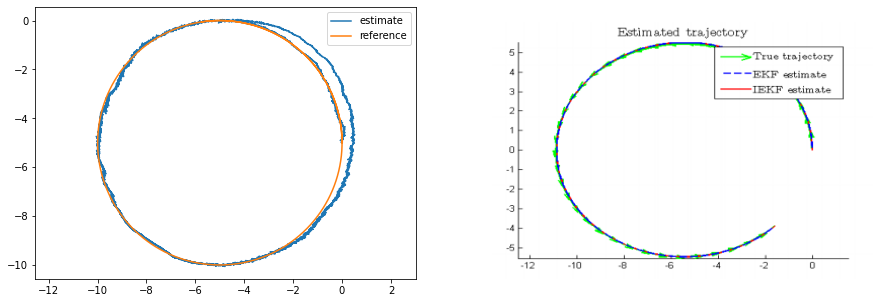

In [7]:
figure(figsize=(15, 5))
subplot(121)
plot(xe_x,xe_y, label='estimate')
plot(xr_x,xr_y, label='reference')
legend(loc='best')
axis('equal');
subplot(122)
imshow(imread('./images/fig1.png'))
gca().get_xaxis().set_visible(False)
gca().get_yaxis().set_visible(False)
axis('off')
axis('tight')

In [8]:
error = []
for i in range(step):
    error_x = ita[i][0][2]
    error_y = ita[i][1][2]
    error.append(sqrt(error_x**2+error_y**2))

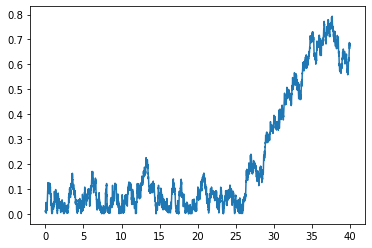

In [9]:
t_x = np.linspace(0, t, step)
plot(t_x ,error)

In [10]:
error_att = []
for i in range(step):
    error_theta = math.acos(ita[i][0][0])*180/pi
    error_att.append(error_theta)

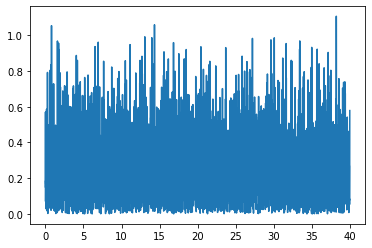

In [11]:
plot(t_x, error_att)

In [12]:
Xe

[array([[ 6.42898020e-04, -9.99999793e-01, -3.44929699e-03],
        [ 9.99999793e-01,  6.42898020e-04, -4.99263833e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[ 0.00595629, -0.99998226, -0.03799829],
        [ 0.99998226,  0.00595629, -4.9897671 ],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[-0.00722556, -0.9999739 ,  0.0157588 ],
        [ 0.9999739 , -0.00722556, -4.96876496],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[-1.12480463e-02, -9.99936739e-01,  4.54102981e-03],
        [ 9.99936739e-01, -1.12480463e-02, -4.95674502e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[-1.29258975e-02, -9.99916457e-01,  2.15816347e-03],
        [ 9.99916457e-01, -1.29258975e-02, -4.94707178e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[-1.69450428e-02, -9.99856422e-01,  2.46331372e-03],
        [ 9.99856422e-01, -1.69450428e-02, -4.93505037e+00],
        [ 0.00000000e+00,

In [13]:
X

[array([[-1.99999867e-03, -9.99998000e-01, -9.99999667e-06],
        [ 9.99998000e-01, -1.99999867e-03, -4.99000001e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[-3.99998933e-03, -9.99992000e-01, -3.99999467e-05],
        [ 9.99992000e-01, -3.99998933e-03, -4.98000005e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[-5.99996400e-03, -9.99982000e-01, -8.99997300e-05],
        [ 9.99982000e-01, -5.99996400e-03, -4.97000018e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[-7.99991467e-03, -9.99968000e-01, -1.59999147e-04],
        [ 9.99968000e-01, -7.99991467e-03, -4.96000043e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[-9.99983333e-03, -9.99950000e-01, -2.49997917e-04],
        [ 9.99950000e-01, -9.99983333e-03, -4.95000083e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[-1.19997120e-02, -9.99928001e-01, -3.59995680e-04],
        [ 9.99

In [14]:
ita

[array([[ 0.99999651,  0.00264289,  0.00974875],
        [-0.00264289,  0.99999651, -0.00265578],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[ 0.99995044,  0.00995616,  0.01162339],
        [-0.00995616,  0.99995044, -0.01001427],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[ 0.99999925, -0.00122562,  0.00975747],
        [ 0.00122562,  0.99999925,  0.0012316 ],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[ 0.99999472, -0.00324828, -0.01141043],
        [ 0.00324828,  0.99999472,  0.00322975],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[ 0.99999572, -0.00292625, -0.0120768 ],
        [ 0.00292625,  0.99999572,  0.00290859],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[ 0.99998777, -0.00494583, -0.02160912],
        [ 0.00494583,  0.99998777,  0.00489243],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[ 0.99999745, -0.00225739, -0.02787954],
        [ 0.00225739,  0.99999745,  0.00222593],
        

In [15]:
Xi = array([[pi/4,0,0]]).T

In [16]:
np.cov(Xi)

/home/jgoppert/anaconda3/envs/uli-mc/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Degrees of freedom <= 0 for slice
  """Entry point for launching an IPython kernel.
/home/jgoppert/anaconda3/envs/uli-mc/lib/python3.7/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/jgoppert/anaconda3/envs/uli-mc/lib/python3.7/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])